# Original Mango testing on the classifiers

# Classifier Codes

In [1]:
import numpy as np
import random


In [2]:
from scipy.stats import uniform

In [3]:
conf_Dict = dict()
conf_Dict['batch_size'] = 1
conf_Dict['initial_random'] = 2
conf_Dict['num_iteration'] = 20

In [4]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

bcancer = datasets.load_breast_cancer()
X = bcancer.data
Y = bcancer.target

In [5]:
print(X.shape,Y.shape)

(569, 30) (569,)


# KNN Classifier

In [6]:
param_dict_knn = {"n_neighbors": range(1, 100),
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

In [7]:
X_knn = X
Y_knn = Y

def objective_knn(args_list):
    global X_knn,Y_knn
    
    results = []
    for hyper_par in args_list:
        clf = KNeighborsClassifier(**hyper_par)
        result  = cross_val_score(clf, X_knn, Y_knn, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

# SVM Classifier

In [8]:
from mango.domain.distribution import loguniform
from sklearn import svm

param_dict_svm = {"gamma": uniform(0.1, 4),
              "C": loguniform(-7, 10)}

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)


X_svm = X #pca.fit_transform(X)
Y_svm = Y

print(X_svm.shape, Y_svm.shape)

def objective_svm(args_list):
    global X_svm,Y_svm
    
    results = []
    for hyper_par in args_list:
        clf = svm.SVC(random_state = 0)
        
        clf.set_params(**hyper_par)
        
        result  = cross_val_score(clf, X_svm, Y_svm, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

(569, 30) (569,)


# Neural Network

In [10]:
param_space_nn = dict(num_of_nodes=range(10, 1000))

In [11]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(num_of_nodes):
    global X_nn, Y_nn
    model = Sequential()
    #model.add(Dense(4, input_dim=X.shape[1], activation='relu'))
    # Hidden dimension of layers = num_of_nodes
    model.add(Dense(num_of_nodes, input_dim=X_nn.shape[1], activation='relu'))
        
    model.add(Dense(Y_nn.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
    
    return model

In [12]:
from keras.utils import np_utils


X_nn = X 
Y_nn = np_utils.to_categorical(Y, 2)

print(Y_nn.shape)

def objective_nn(args_list):
    global X_nn, Y_nn
    
    results  = []
    for hyper_par in args_list:
        
        model = get_model(**hyper_par)

        #train the clf.
        model.fit(X_nn, Y_nn,
              batch_size=32,
              epochs=10,
              verbose=0)

        score = model.evaluate(X_nn,Y_nn, verbose=0)
        
        results.append(score[1])
    
   
    return results

(569, 2)


Using TensorFlow backend.


# Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier

param_dict_dtree = {
              "max_features": ['auto', 'sqrt', 'log2'],
               "max_depth": range(1,20),     
               "splitter":['best','random'],
               "criterion":['gini','entropy']
             }

In [14]:

X_dtree = X 
Y_dtree = Y

print(X_dtree.shape, Y_dtree.shape)

def objective_dtree(args_list):
    global X_dtree,Y_dtree
    
    results = []
    for hyper_par in args_list:
        clf =  DecisionTreeClassifier(random_state = 0)
        
        clf.set_params(**hyper_par)
        result  = cross_val_score(clf, X_dtree, Y_dtree, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

(569, 30) (569,)


# XGBoost

In [15]:
from xgboost import XGBClassifier

param_dict_xgboost = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1, 15),
              "n_estimators": range(1, 3),
               "booster":['gbtree','gblinear','dart']
             }


X_xgboost = X 
Y_xgboost = Y

# import warnings
# warnings.filterwarnings('ignore')

def objective_xgboost(args_list):
    global X_xgboost, Y_xgboost

    results = []
    for hyper_par in args_list:
        #clf = XGBClassifier(**hyper_par)
        clf = XGBClassifier(verbosity = 0, random_state = 0)
        
        #clf = XGBClassifier()
        clf.set_params(**hyper_par)

        result = cross_val_score(clf, X_xgboost, Y_xgboost, scoring='accuracy', cv=3).mean()
        results.append(result)
    return results

# Do the several experiments

In [36]:
all_results = []

In [17]:
all_seeds =[i for i in range(5)]

from mango.tuner import Tuner



for seed in all_seeds:
    
    print("seed is:",seed)
    np.random.seed(seed)
    random.seed(seed)
    tuner_knn = Tuner(param_dict_knn, objective_knn, conf_Dict)
    tuner_knn.seed = seed
    
    np.random.seed(seed)
    random.seed(seed)
    tuner_svm = Tuner(param_dict_svm, objective_svm, conf_Dict)
    tuner_svm.seed = seed
    
    np.random.seed(seed)
    random.seed(seed)
    tuner_nn = Tuner(param_space_nn, objective_nn, conf_Dict)
    tuner_nn.seed = seed
    
    np.random.seed(seed)
    random.seed(seed)
    tuner_dtree = Tuner(param_dict_dtree, objective_dtree, conf_Dict)
    tuner_dtree.seed = seed
    
    np.random.seed(seed)
    random.seed(seed)
    tuner_xgboost = Tuner(param_dict_xgboost, objective_xgboost, conf_Dict)
    tuner_xgboost.seed = seed
    
    
    results_knn = tuner_knn.maximize()
    results_svm = tuner_svm.maximize()
    results_nn = tuner_nn.maximize()
    results_dtree = tuner_dtree.maximize()
    results_xgboost = tuner_xgboost.maximize()
    
    all_results.append([results_knn, results_svm, results_nn, results_dtree, results_xgboost])
    
    

# Save the raw results

In [49]:
import pickle

with open('data/bcancer_tuner_raw.pickle', 'wb') as f:
    pickle.dump(all_results, f)

In [50]:
# Load the data

with open('data/bcancer_tuner_raw.pickle', 'rb') as f:
    all_results = pickle.load(f)

 # Load the data for Plots

In [34]:
# Load the data

import pickle

with open('data/bcancer_tuner_raw.pickle', 'rb') as f:
    all_results = pickle.load(f)

# Plot the variation of several seeds

In [35]:
y_knn = []
y_svm = []
y_nn = []
y_dtree = []
y_xgboost = []
 
for res in all_results:
    results_knn, results_svm, results_nn, results_dtree, results_xgboost = res
    
    results_obj_knn = np.array(results_knn['objective_values'])

    y_max_knn=[]
    for i in range(results_obj_knn.shape[0]):
        y_max_knn.append(np.max(results_obj_knn[:i+2]))


    results_obj_svm = np.array(results_svm['objective_values'])

    y_max_svm=[]
    for i in range(results_obj_svm.shape[0]):
        y_max_svm.append(np.max(results_obj_svm[:i+2]))



    results_obj_nn = np.array(results_nn['objective_values'])

    y_max_nn=[]
    for i in range(results_obj_nn.shape[0]):
        y_max_nn.append(np.max(results_obj_nn[:i+2]))



    results_obj_dtree = np.array(results_dtree['objective_values'])

    y_max_dtree=[]
    for i in range(results_obj_dtree.shape[0]):
        y_max_dtree.append(np.max(results_obj_dtree[:i+2]))


    results_obj_xgboost = np.array(results_xgboost['objective_values'])

    y_max_xgboost=[]
    for i in range(results_obj_xgboost.shape[0]):
        y_max_xgboost.append(np.max(results_obj_xgboost[:i+2]))
        
    
    
    y_knn.append(y_max_knn)
    y_svm.append(y_max_svm)
    y_nn.append(y_max_nn)
    y_dtree.append(y_max_dtree)
    y_xgboost.append(y_max_xgboost)
    
    
    

In [36]:
y_knn = np.array(y_knn)
y_svm = np.array(y_svm)
y_nn = np.array(y_nn)
y_dtree = np.array(y_dtree)
y_xgboost = np.array(y_xgboost)

In [39]:
avg_y_knn = np.mean(y_knn,axis = 0)
min_y_knn = np.min(y_knn,axis = 0)
max_y_knn = np.max(y_knn,axis = 0)

avg_y_svm = np.mean(y_svm,axis = 0)
min_y_svm = np.min(y_svm,axis = 0)
max_y_svm = np.max(y_svm,axis = 0)

avg_y_nn = np.mean(y_nn,axis = 0)
min_y_nn = np.min(y_nn,axis = 0)
max_y_nn = np.max(y_nn,axis = 0)

avg_y_dtree = np.mean(y_dtree,axis = 0)
min_y_dtree = np.min(y_dtree,axis = 0)
max_y_dtree = np.max(y_dtree,axis = 0)

avg_y_xgboost = np.mean(y_xgboost,axis = 0)
min_y_xgboost = np.min(y_xgboost,axis = 0)
max_y_xgboost = np.max(y_xgboost,axis = 0)


In [40]:
avg_y_knn.shape

(22,)

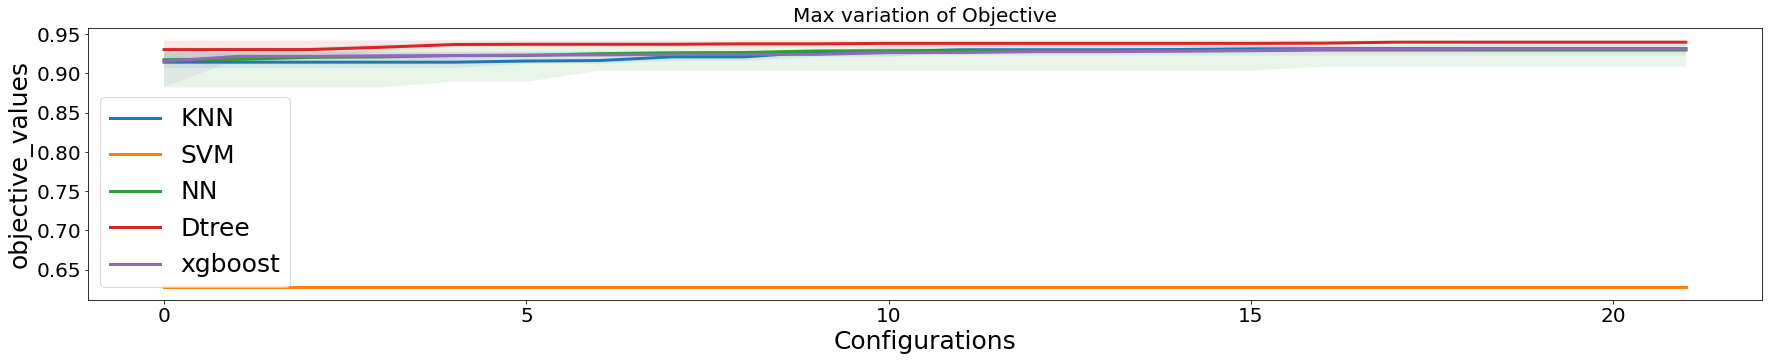

In [41]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)

plt.plot(avg_y_knn, linewidth=3, label= "KNN")
plt.plot(avg_y_svm, linewidth=3, label= "SVM")
plt.plot(avg_y_nn, linewidth=3, label= "NN")
plt.plot(avg_y_dtree, linewidth=3, label= "Dtree")
plt.plot(avg_y_xgboost, linewidth=3, label= "xgboost")





Time = [i for i in range(avg_y_knn.shape[0])]

plt.fill_between(Time, min_y_knn, max_y_knn, alpha=0.1)
plt.fill_between(Time, min_y_svm, max_y_svm, alpha=0.1)
plt.fill_between(Time, min_y_nn, max_y_nn, alpha=0.1)
plt.fill_between(Time, min_y_dtree, max_y_dtree, alpha=0.1)
plt.fill_between(Time, min_y_xgboost, max_y_xgboost, alpha=0.1)



plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 25})
plt.show()



# Plot the Mango max variation

In [42]:
# Collect max of every run

y_knn = []
y_svm = []
y_nn = []
y_dtree = []
y_xgboost = []

all_results_variation = []
 
for res in all_results:
    results_knn, results_svm, results_nn, results_dtree, results_xgboost = res
    
    results_obj_knn = np.array(results_knn['objective_values'])

    y_max_knn=[]
    for i in range(results_obj_knn.shape[0]):
        y_max_knn.append(np.max(results_obj_knn[:i+2]))


    results_obj_svm = np.array(results_svm['objective_values'])

    y_max_svm=[]
    for i in range(results_obj_svm.shape[0]):
        y_max_svm.append(np.max(results_obj_svm[:i+2]))



    results_obj_nn = np.array(results_nn['objective_values'])

    y_max_nn=[]
    for i in range(results_obj_nn.shape[0]):
        y_max_nn.append(np.max(results_obj_nn[:i+2]))



    results_obj_dtree = np.array(results_dtree['objective_values'])

    y_max_dtree=[]
    for i in range(results_obj_dtree.shape[0]):
        y_max_dtree.append(np.max(results_obj_dtree[:i+2]))


    results_obj_xgboost = np.array(results_xgboost['objective_values'])

    y_max_xgboost=[]
    for i in range(results_obj_xgboost.shape[0]):
        y_max_xgboost.append(np.max(results_obj_xgboost[:i+2]))
        
    results = [results_obj_knn, results_obj_svm, results_obj_nn, results_obj_dtree, y_max_xgboost]

    results = np.array(results)
    
    results_variation = []
    configs = []

    for i in range(results.shape[1]):
        max_val = np.max(results[:,:(i+2)])
        results_variation.append(max_val)
        configs.append((i)*results.shape[0])
    
    all_results_variation.append(results_variation)
    
    

In [43]:
all_results_variation = np.array(all_results_variation)
print(all_results_variation.shape)

(6, 22)


In [44]:
avg_tuner = np.mean(all_results_variation,axis = 0)
min_tuner = np.min(all_results_variation,axis = 0)
max_tuner = np.max(all_results_variation,axis = 0)

In [45]:
avg_tuner.shape

(22,)

In [46]:
#configs

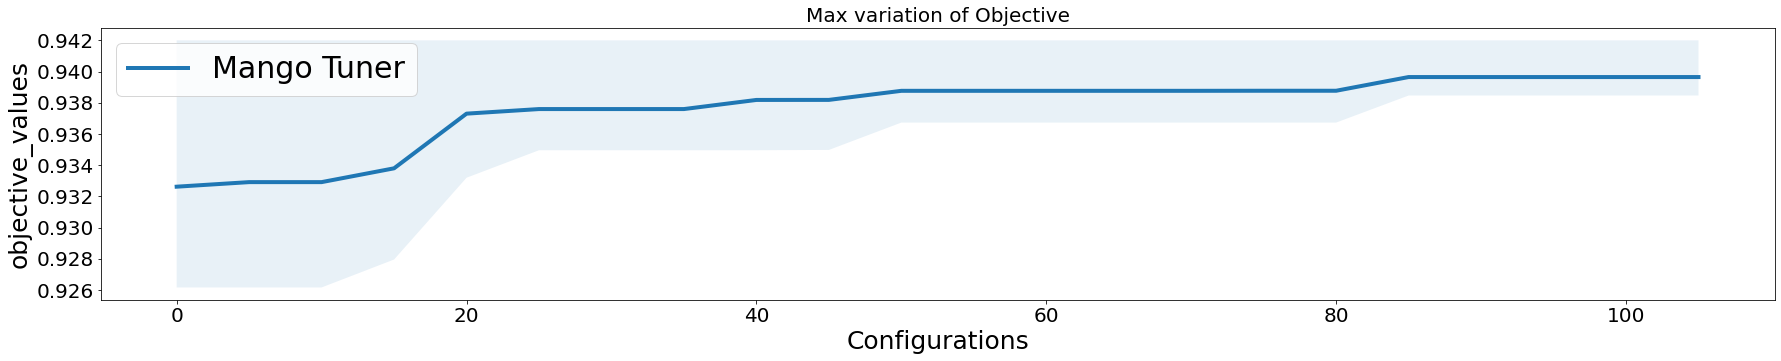

In [47]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)


plt.plot(configs, avg_tuner,lw=4,label='Mango Tuner')


plt.fill_between(configs, min_tuner, max_tuner, alpha=0.1)

plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# Comparisons of Tuner with MetaTuner

In [48]:
# Tuner results
# Load the data

with open('data/bcancer_tuner_raw.pickle', 'rb') as f:
    all_results = pickle.load(f)
    
        
# Collect max of every run

y_knn = []
y_svm = []
y_nn = []
y_dtree = []
y_xgboost = []

all_results_variation = []

random_dones = 2
    
for res in all_results:
    results_knn, results_svm, results_nn, results_dtree, results_xgboost = res
    
    results_obj_knn = np.array(results_knn['objective_values'])

    y_max_knn=[]
    for i in range(results_obj_knn.shape[0]):
        y_max_knn.append(np.max(results_obj_knn[:i+random_dones]))


    results_obj_svm = np.array(results_svm['objective_values'])

    y_max_svm=[]
    for i in range(results_obj_svm.shape[0]):
        y_max_svm.append(np.max(results_obj_svm[:i+random_dones]))



    results_obj_nn = np.array(results_nn['objective_values'])

    y_max_nn=[]
    for i in range(results_obj_nn.shape[0]):
        y_max_nn.append(np.max(results_obj_nn[:i+random_dones]))



    results_obj_dtree = np.array(results_dtree['objective_values'])

    y_max_dtree=[]
    for i in range(results_obj_dtree.shape[0]):
        y_max_dtree.append(np.max(results_obj_dtree[:i+random_dones]))


    results_obj_xgboost = np.array(results_xgboost['objective_values'])

    y_max_xgboost=[]
    for i in range(results_obj_xgboost.shape[0]):
        y_max_xgboost.append(np.max(results_obj_xgboost[:i+random_dones]))
        
    results = [results_obj_knn, results_obj_svm, results_obj_nn, results_obj_dtree, y_max_xgboost]

    results = np.array(results)
    
    results_variation = []
    configs = []

    for i in range(results.shape[1]):
        max_val = np.max(results[:,:(i+2)])
        results_variation.append(max_val)
        configs.append((i)*results.shape[0])
    
    all_results_variation.append(results_variation)
    

configs_tuner = configs

In [49]:
all_results_variation = np.array(all_results_variation)
print(all_results_variation.shape)
avg_tuner = np.mean(all_results_variation,axis = 0)
min_tuner = np.min(all_results_variation,axis = 0)
max_tuner = np.max(all_results_variation,axis = 0)


(6, 22)


In [54]:
# Meta Tuner data and results

with open('data/MetaTune_bcancer_serial.pickle.pickle', 'rb') as f:
    objective_values = pickle.load(f)
    
objective_values = np.array(objective_values)

results_variation = []

for j in range(objective_values.shape[0]):
    values = []
    for i in range(objective_values.shape[1]-10):
        val = np.max(objective_values[j,:(i+10)])
        #print(j,i,val)
        values.append(val)
    
    results_variation.append(values)


all_results_variation = np.array(results_variation)

print(all_results_variation.shape)

avg_metatuner_1 = np.mean(all_results_variation,axis = 0)
min_metatuner_1 = np.min(all_results_variation,axis = 0)
max_metatuner_1 = np.max(all_results_variation,axis = 0)

print(avg_metatuner_1.shape)

(5, 100)
(100,)


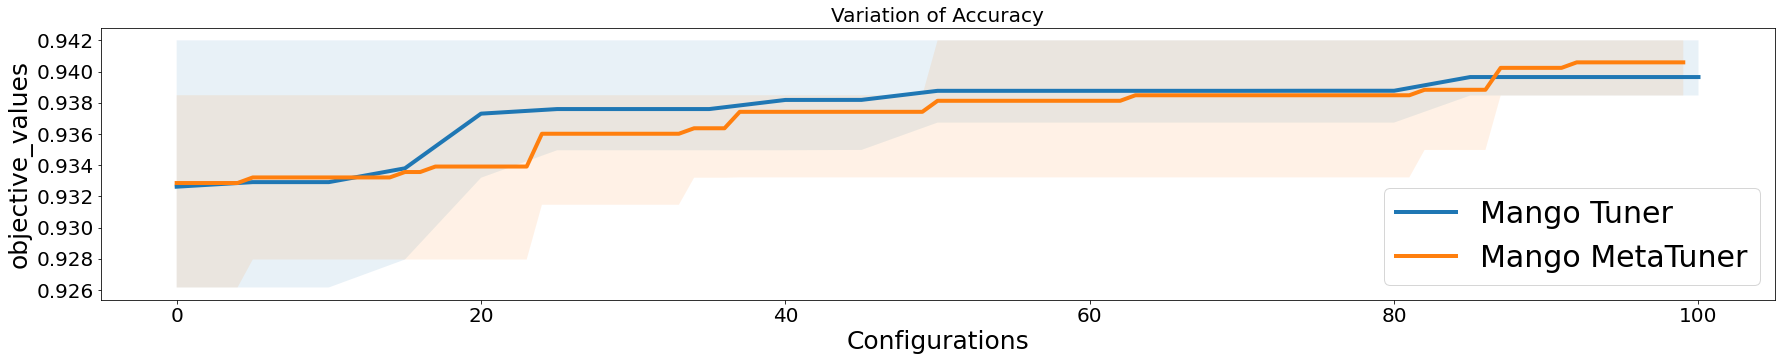

In [55]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Variation of Accuracy',fontsize=20)


plt.plot(configs_tuner[:21], avg_tuner[:21],lw=4,label='Mango Tuner')

configs_metatuner = [i for i in range(all_results_variation.shape[1])]
plt.plot(configs_metatuner, avg_metatuner_1,lw=4,label='Mango MetaTuner')





plt.fill_between(configs_tuner[:21], min_tuner[:21], max_tuner[:21], alpha=0.1)
plt.fill_between(configs_metatuner, min_metatuner_1, max_metatuner_1, alpha=0.1)





plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)

#xticks_labels = 

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',prop={'size': 30})

plt.show()